# Thinkful Unsupervised Capstone
### Using supervised and unsupervised NLP techniques for feature generation and selection and clustering

Data Source: mtsamples.com

In [1]:
import pandas as pd
import numpy as np
import scipy

import spacy
from spacy import displacy
import nltk
import re

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

np.random.seed(27)

In [2]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22})

sns.set_palette('bright')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [3]:
# read in the data
raw_data = pd.read_csv('mtsamples.csv')
raw_data.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


### Clean, Normalize, and Pre-process Text
Before attempting to apply any machine learning algorithms we must first pre-process our text.  This step includes removing stop-words and unnecessary punctuations.

Pre-processing techniques to try:
 - tokenization
 - tagging
 - chunking
 - lemmatization

In [4]:
# visualizing a sample text
sample_text = raw_data.iloc[0,4]
sample_text

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

I can see right away here that numbers and some punctuations are definitely important.  For example we need to keep the / in the blood pressure measurement as without it the reading becomes meaningless.  Also, especially in medical data age is important.  We would treat a 23 year old much differently than a 3 or 93 year old.

In [5]:
# trying out potential tokenizers
# visualizing output with nltk default sentence tokenizer
nltk.sent_tokenize(text=sample_text)

['SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.',
 'She used to have allergies when she lived in Seattle but she thinks they are worse here.',
 'In the past, she has tried Claritin, and Zyrtec.',
 'Both worked for short time but then seemed to lose effectiveness.',
 'She has used Allegra also.',
 'She used that last summer and she began using it again two weeks ago.',
 'It does not appear to be working very well.',
 'She has used over-the-counter sprays but no prescription nasal sprays.',
 'She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.',
 'Nasal mucosa was erythematous and swollen.',
 'Only clear drainage was seen.',
 'TMs were clear.,

In [6]:
# viewing output for RegExpTokenizer
SENTENCE_TOKENS_PATTERN = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<![A-Z]\.)(?<=\.|\?|\!)\s'
regex_st = nltk.tokenize.RegexpTokenizer(
            pattern=SENTENCE_TOKENS_PATTERN,
            gaps=True)
regex_st.tokenize(sample_text)

['SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.',
 ' She used to have allergies when she lived in Seattle but she thinks they are worse here.',
 ' In the past, she has tried Claritin, and Zyrtec.',
 ' Both worked for short time but then seemed to lose effectiveness.',
 ' She has used Allegra also.',
 ' She used that last summer and she began using it again two weeks ago.',
 ' It does not appear to be working very well.',
 ' She has used over-the-counter sprays but no prescription nasal sprays.',
 ' She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.',
 ' Nasal mucosa was erythematous and swollen.',
 ' Only clear drainage was seen.',
 ' TMs w

Neither sentence tokenizer above was able to correctly tokenize the sentences.  Let's try applying some cleaning functions to see if we can get a better result.

In [7]:
# functions modified from: 
# https://github.com/dipanjanS/text-analytics-with-python/blob/master/Old_Edition_v1/notebooks/Ch03_Processing_and_Understanding_Text/normalizer.py

def tokenize_text(text):
    sentences = nltk.sent_tokenize(text)
    word_tokens = [nltk.word_tokenize(sentence) for sentence in sentences] 
    return word_tokens

def remove_characters_before_tokenization(sentence, keep_dash=True):
    sentence = sentence.strip()
    if keep_dash:
        # removing most special characters
        # we want to keep at least - and / as these are important in this text
        PATTERN = r'[?|$|&|*|%|@|(|)|~|,|]'
        filtered_sentence = re.sub(PATTERN, r'', sentence)
        # replacing : with whitespace to ensure words don't run together
        filtered_sentence = re.sub(r'[:]', ' ', filtered_sentence)
        # adding whitespace after . to help tokenizer capture correct sentences
        filtered_sentence = re.sub(r'[.]', ' ', filtered_sentence)
    else:
        PATTERN = r'[^a-zA-Z0-9 ]'
        filtered_sentence = re.sub(PATTERN, r'', sentence)
    return filtered_sentence

# visualizing test output
cleaned_sample = remove_characters_before_tokenization(sample_text) 
cleaned_sample

'SUBJECTIVE   This 23-year-old white female presents with complaint of allergies   She used to have allergies when she lived in Seattle but she thinks they are worse here   In the past she has tried Claritin and Zyrtec   Both worked for short time but then seemed to lose effectiveness   She has used Allegra also   She used that last summer and she began using it again two weeks ago   It does not appear to be working very well   She has used over-the-counter sprays but no prescription nasal sprays   She does have asthma but doest not require daily medication for this and does not think it is flaring up MEDICATIONS   Her only medication currently is Ortho Tri-Cyclen and the Allegra ALLERGIES   She has no known medicine allergies OBJECTIVE Vitals   Weight was 130 pounds and blood pressure 124/78 HEENT   Her throat was mildly erythematous without exudate   Nasal mucosa was erythematous and swollen   Only clear drainage was seen   TMs were clear Neck   Supple without adenopathy Lungs   Clea

In [8]:
# this looks much better!
nltk.sent_tokenize(text=cleaned_sample)

['SUBJECTIVE   This 23-year-old white female presents with complaint of allergies   She used to have allergies when she lived in Seattle but she thinks they are worse here   In the past she has tried Claritin and Zyrtec   Both worked for short time but then seemed to lose effectiveness   She has used Allegra also   She used that last summer and she began using it again two weeks ago   It does not appear to be working very well   She has used over-the-counter sprays but no prescription nasal sprays   She does have asthma but doest not require daily medication for this and does not think it is flaring up MEDICATIONS   Her only medication currently is Ortho Tri-Cyclen and the Allegra ALLERGIES   She has no known medicine allergies OBJECTIVE Vitals   Weight was 130 pounds and blood pressure 124/78 HEENT   Her throat was mildly erythematous without exudate   Nasal mucosa was erythematous and swollen   Only clear drainage was seen   TMs were clear Neck   Supple without adenopathy Lungs   Cle

With a little cleaning, the sentence tokenizer performed much better!  Let's now modify our cleaning function from above.  We should add functionality to remove stop words and further normalize the text by removing capitol letters.

From viewing the sample text, I think the categories that are written in all caps may be an important feature, but lets go ahead and lowercase everything for now.

In [9]:
def normalize_text(doc):
    doc = doc.lower()
    # removing most special characters
    # we want to keep at least - and / as these are important in this text
    PATTERN = r'[?|$|&|*|%|@|(|)|~|,|]'
    doc = re.sub(PATTERN, r'', doc)
    # replacing : with whitespace to ensure words don't run together
    doc = re.sub(r'[:]', ' ', doc)
    # replacing . with whitespace to help tokenizer capture correct sentences
    doc = re.sub(r'[.]', ' ', doc)
    # removing extra whitespace
    doc = doc.replace('   ', ' ')
    doc = doc.strip()
    
    return doc

sample_normalized = normalize_text(sample_text)
sample_normalized

'subjective this 23-year-old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seemed to lose effectiveness she has used allegra also she used that last summer and she began using it again two weeks ago it does not appear to be working very well she has used over-the-counter sprays but no prescription nasal sprays she does have asthma but doest not require daily medication for this and does not think it is flaring up medications her only medication currently is ortho tri-cyclen and the allegra allergies she has no known medicine allergies objective vitals weight was 130 pounds and blood pressure 124/78 heent her throat was mildly erythematous without exudate nasal mucosa was erythematous and swollen only clear drainage was seen tms were clear neck supple without adenopathy lungs clear assessment allergic rhinitis plan 

In [10]:
# tokenize the transcriptions with spacy
# using spacys full vector package - I feel like medical transcriptions will benefit from the larger vocabulary
nlp = spacy.load('en_core_web_lg')

In [11]:
# source: https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch07_Analyzing_Movie_Reviews_Sentiment/Text%20Normalization%20Demo.ipynb

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [12]:
# lemmatizing corpus

lemma_sample = lemmatize_text(sample_normalized)
print(type(lemma_sample))
lemma_sample = nlp(lemma_sample)
print(type(lemma_sample))
lemma_sample

<class 'str'>
<class 'spacy.tokens.doc.Doc'>


subjective this 23-year - old white female present with complaint of allergy she use to have allergy when she live in seattle but she think they be bad here in the past she have try claritin and zyrtec both work for short time but then seem to lose effectiveness she have use allegra also she use that last summer and she begin use it again two week ago it do not appear to be work very well she have use over - the - counter spray but no prescription nasal spray she do have asthma but doest not require daily medication for this and do not think it be flare up medication her only medication currently be ortho tri - cyclen and the allegra allergy she have no know medicine allergi objective vital weight be 130 pound and blood pressure 124/78 heent her throat be mildly erythematous without exudate nasal mucosa be erythematous and swollen only clear drainage be see tms be clear neck supple without adenopathy lung clear assessment allergic rhinitis plan 1 she will try zyrtec instead of allegra 

In [13]:
tokens = [token.text for token in lemma_sample if not token.is_stop]
tokens[0:10]

['subjective',
 'this',
 '23-year',
 '-',
 'old',
 'white',
 'female',
 'present',
 'with',
 'complaint']

In [14]:
# using spacy to visualize a named entity annotated transcription
displacy.render(lemma_sample, style='ent', jupyter=True)

In [15]:
# visualizing the dependency tree for the first sentenece in our sample transcription

doc = nlp('subjective this 23-year - old white female present with complaint of allergy')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

This looks pretty good so far.  Let's go ahead and start applying the functions to each transcription sample.

In [16]:
# first checking our transcriptions for null values
raw_data.transcription.isnull().sum()

33

In [17]:
# dropping the 33 rows with no transcription text
df = raw_data.copy()
df.dropna(subset=['transcription'], inplace=True)

print('Transcriptions with null values:')
print(df.transcription.isnull().sum())

df.head()

Transcriptions with null values:
0


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [18]:
# also dropping the unnnamed column as it doesnt provide any value
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [19]:
normalize_corpus = np.vectorize(normalize_text)
df['transcriptions_normal'] = normalize_corpus(df.transcription)

In [20]:
df['lemma_transcription'] = [lemmatize_text(item) for item in df.transcriptions_normal]

In [21]:
df.head()

,description,medical_specialty,sample_name,transcription,keywords,transcriptions_normal,lemma_transcription
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",subjective this 23-year-old white female prese...,subjective this 23-year - old white female pre...
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...",past medical history he has difficulty climbi...,past medical history he have difficulty clim...
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",history of present illness i have seen abc tod...,history of present illness i have see abc toda...
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",2-d m-mode 1 left atrial enlargement with left...,2-d m - mode 1 leave atrial enlargement with l...
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",1 the left ventricular cavity size and wall th...,1 the left ventricular cavity size and wall th...


While I believe some special characters and numbers are important for our transcriptions, I think they will add unneeded noise in our clustering.  Let's write a function to further clean the text to get ready for our clustering below.

In [22]:
# loading nltk stopwords
stop_words = nltk.corpus.stopwords.words('english')

# from visual inspection of corpus adding to our stopword list
more_stops = ['aa', 'ab', 'abc', 'abcd', 'xxx', 'xyz', 'xii', 'dr', 'x', 'mg', 'p', 'ml']

stop_words = stop_words + more_stops
print (stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()

# remove numbers and stopwords
def remove_stopwords_and_nums(text):
    tokens = tokenizer.tokenize(text)
    # remove all non-alpha characters
    tokens = filter(lambda x: x.isalpha(), tokens)
    tokens = [token.strip() for token in tokens]
    # filter out stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

remove_stopwords_and_nums(lemma_sample)

'subjective old white female present complaint allergy use allergy live seattle think bad past try claritin zyrtec work short time seem lose effectiveness use allegra also use last summer begin use two week ago appear work well use counter spray prescription nasal spray asthma doest require daily medication think flare medication medication currently ortho tri cyclen allegra allergy know medicine allergi objective vital weight pound blood pressure heent throat mildly erythematous without exudate nasal mucosa erythematous swollen clear drainage see tms clear neck supple without adenopathy lung clear assessment allergic rhinitis plan try zyrtec instead allegra another option use loratadine think prescription coverage may cheap sample nasonex two spray nostril give three week prescription write well'

In [24]:
df['alpha_only'] = [remove_stopwords_and_nums(item) for item in df.lemma_transcription]
df['alpha_tokens'] = [tokenizer.tokenize(text) for text in df.alpha_only]
df.sample(5)

,description,medical_specialty,sample_name,transcription,keywords,transcriptions_normal,lemma_transcription,alpha_only,alpha_tokens
279,"History of compartment syndrome, right lower ...",Surgery,Tissue Expander Insertion,"PREOPERATIVE DIAGNOSES: , History of compartme...","surgery, fasciotomy, subcutaneous, muscle, wou...",preoperative diagnoses history of compartment ...,preoperative diagnosis history of compartment ...,preoperative diagnosis history compartment syn...,"[preoperative, diagnosis, history, compartment..."
2688,Phenol neurolysis left musculocutaneous nerve...,Neurosurgery,Phenol Neurolysis & Botulinum Toxin Injection...,"PROCEDURES PERFORMED:, Phenol neurolysis left...","neurosurgery, spastic quadriparesis, emg stimu...",procedures performed phenol neurolysis left mu...,procedure perform phenol neurolysis leave musc...,procedure perform phenol neurolysis leave musc...,"[procedure, perform, phenol, neurolysis, leave..."
1425,Postoperative visit for craniopharyngioma wit...,SOAP / Chart / Progress Notes,Craniopharyngioma - Postop,"REASON FOR VISIT:, Postoperative visit for cr...","soap / chart / progress notes, visual acuity, ...",reason for visit postoperative visit for crani...,reason for visit postoperative visit for crani...,reason visit postoperative visit craniopharyng...,"[reason, visit, postoperative, visit, cranioph..."
3920,"Hypothermia. Rule out sepsis, was negative a...",Discharge Summary,Hypothermia - Discharge Summary,"DIAGNOSIS AT ADMISSION: , Hypothermia.,DIAGNOS...","discharge summary, sepsis, organic brain syndr...",diagnosis at admission hypothermia diagnoses o...,diagnosis at admission hypothermia diagnosis o...,diagnosis admission hypothermia diagnosis hypo...,"[diagnosis, admission, hypothermia, diagnosis,..."
3483,Patient presents to the emergency department ...,Gastroenterology,Proctitis & Proctocolitis,"PRESENTATION: , A 16-year-old male presents to...",NaN,presentation a 16-year-old male presents to th...,presentation a 16-year - old male present to t...,presentation old male present emergency depart...,"[presentation, old, male, present, emergency, ..."


In [25]:
# creating a list of the total vocabulary for the entire transcriptions corpus
# extend creates a flat list of words
total_vocab = []
for token in df.alpha_tokens:
    total_vocab.extend(token)

# removing duplicate words using set (unordered collection of distinct objects)
total_vocab = list(set(total_vocab))
total_vocab = pd.DataFrame({'words':total_vocab}, index=total_vocab)
total_vocab.sample(5)

,words
mortem,mortem
sensing,sensing
glasgow,glasgow
macrocephaly,macrocephaly
cavagram,cavagram


### Feature Extraction
Feature extraction techniques to try:
 - Bag of Words
 - Bag of N-Grams
 - TF-IDF

#### Bag of Words Model

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=10000)
cv_matrix = cv.fit_transform(df.alpha_only)
cv_matrix = cv_matrix.toarray()
cv_matrix[0:10]

array([[0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [27]:
# get all unique words in corpus
vocab = cv.get_feature_names()
# show feature vectors
pd.DataFrame(cv_matrix, columns=vocab).head()

,abandon,abbreviate,abcdob,abd,abdomen,abdominal,abdominally,abdominis,abdominus,abds,...,zoloft,zone,zonegran,zoster,zosyn,zygoma,zygomatic,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Bag of N-Grams Model

In [28]:
bv = CountVectorizer(ngram_range=(2,3), max_features=10000)
bv_matrix = bv.fit_transform(df.alpha_only)
bv_matrix = bv_matrix.toarray()

vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab).head()

,abdomen abdomen,abdomen benign,abdomen benign extremity,abdomen insufflate,abdomen nontender,abdomen normal,abdomen obese,abdomen pelvi,abdomen pelvis,abdomen positive,...,year also,year history,year old,year old female,year past,year patient,year prior,young age,young lady,young man
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### TF-IDF Model

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(max_features=10000,
                     min_df=2, #use only words appearing at least twice
                     max_df=0.7, #drop words occuring in a majority of the documents
                     stop_words='english',
                     ngram_range=(1,3)
                    )
%time tv_matrix = tv.fit_transform(df.alpha_only)
tv_matrix = tv_matrix.toarray()

# vocabulary of features in tfidf matrix
vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab).head()

CPU times: user 6.26 s, sys: 154 ms, total: 6.42 s
Wall time: 6.43 s


,abd,abdomen,abdomen abdomen,abdomen benign,abdomen insufflate,abdomen nontender,abdomen obese,abdomen pelvi,abdomen pelvis,abdomen positive,...,young man,yyyy,zantac,zero,zithromax,zocor,zofran,zoloft,zone,zyrtec
0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21
1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


#### Document Similarity and Clustering

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = 1 - cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4956,4957,4958,4959,4960,4961,4962,4963,4964,4965
0,-2.220446e-16,9.290941e-01,9.188947e-01,0.998074,9.830007e-01,0.985362,0.974986,0.997787,0.980813,1.000000,...,0.942436,0.976357,0.946613,0.978585,0.904190,0.815593,0.986729,0.761305,0.934697,0.878184
1,9.290941e-01,1.110223e-16,3.746842e-01,0.982467,9.767373e-01,0.978755,0.984741,0.960896,0.994422,1.000000,...,0.854755,0.954105,0.936215,0.959991,0.821836,0.890949,0.957361,0.890272,0.896524,0.872956
2,9.188947e-01,3.746842e-01,-2.220446e-16,0.980015,9.742122e-01,0.923978,0.970332,0.956945,0.985817,0.992411,...,0.764357,0.951033,0.935532,0.960094,0.868660,0.872884,0.943829,0.880110,0.893569,0.879335
3,9.980738e-01,9.824672e-01,9.800150e-01,0.000000,4.846527e-01,0.985915,0.996816,0.702460,1.000000,0.327800,...,0.993503,0.948485,0.974157,0.964747,1.000000,0.975045,0.997223,0.986698,0.995515,0.989175
4,9.830007e-01,9.767373e-01,9.742122e-01,0.484653,-2.220446e-16,0.984033,0.991731,0.642185,0.999194,0.567089,...,0.991623,0.916256,0.966914,0.934670,1.000000,0.957756,0.991380,0.967657,0.987302,0.974648


#### Hierarchical Document Clustering

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
                         'Distance', 'Cluster Size'], dtype='object').head()

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,3,1741,0,2
1,4,1736,0,2
2,5,623,0,2
3,6,590,0,2
4,7,1738,0,2


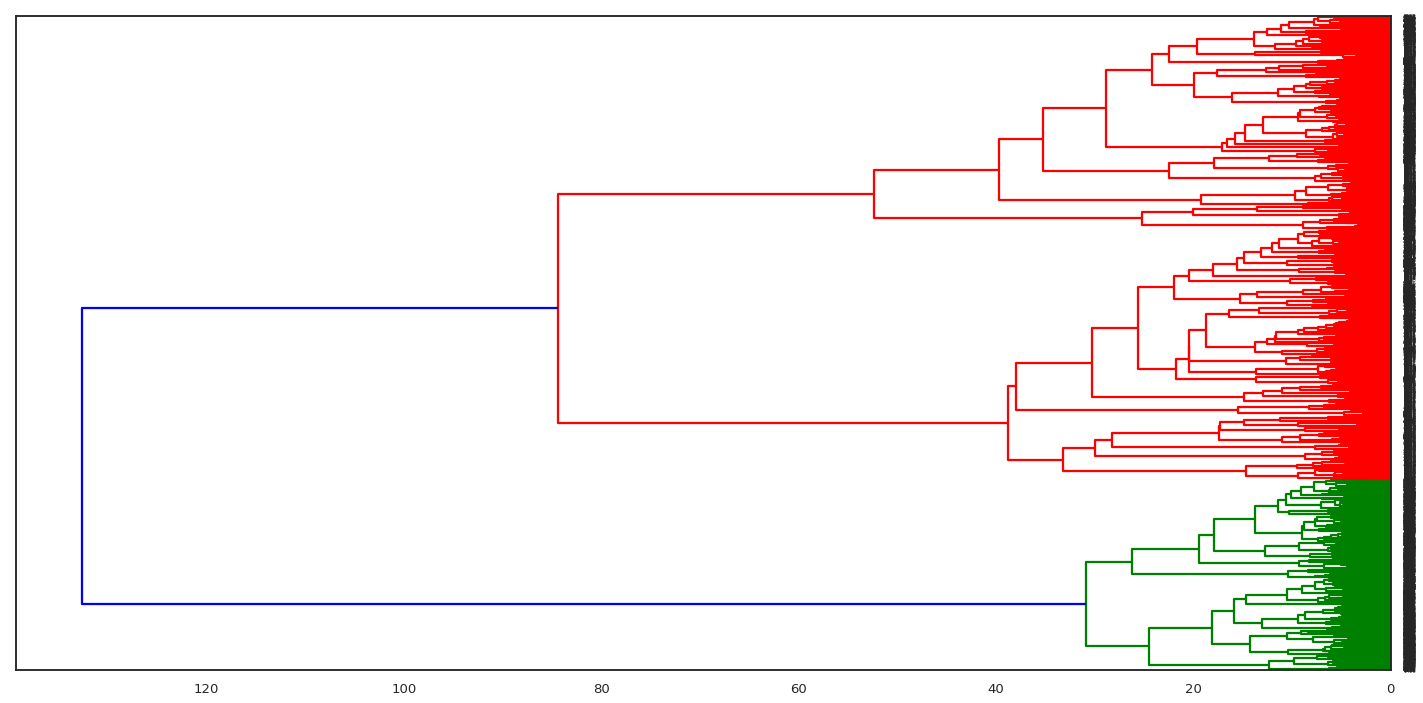

In [32]:
fig, ax = plt.subplots(figsize=(20,10))
ax = dendrogram(Z, 
                orientation='left',
                )
                #labels=df.medical_specialty)
plt.tight_layout();

In [33]:
color_threshold = 0.5*max(Z[:,2])

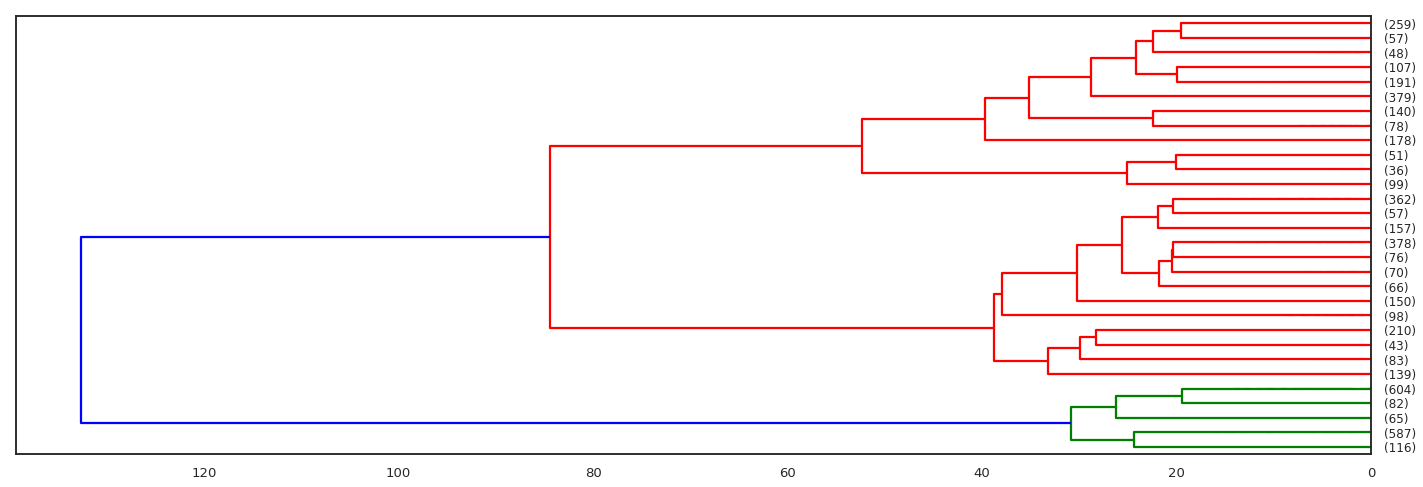

In [34]:
fig, ax = plt.subplots()
ax = dendrogram(Z,
                orientation='left',
                truncate_mode='lastp',
                p=30,
                leaf_font_size=12.,
                show_leaf_counts=True,
                show_contracted=True,
               )
plt.tight_layout();

In [35]:
## https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

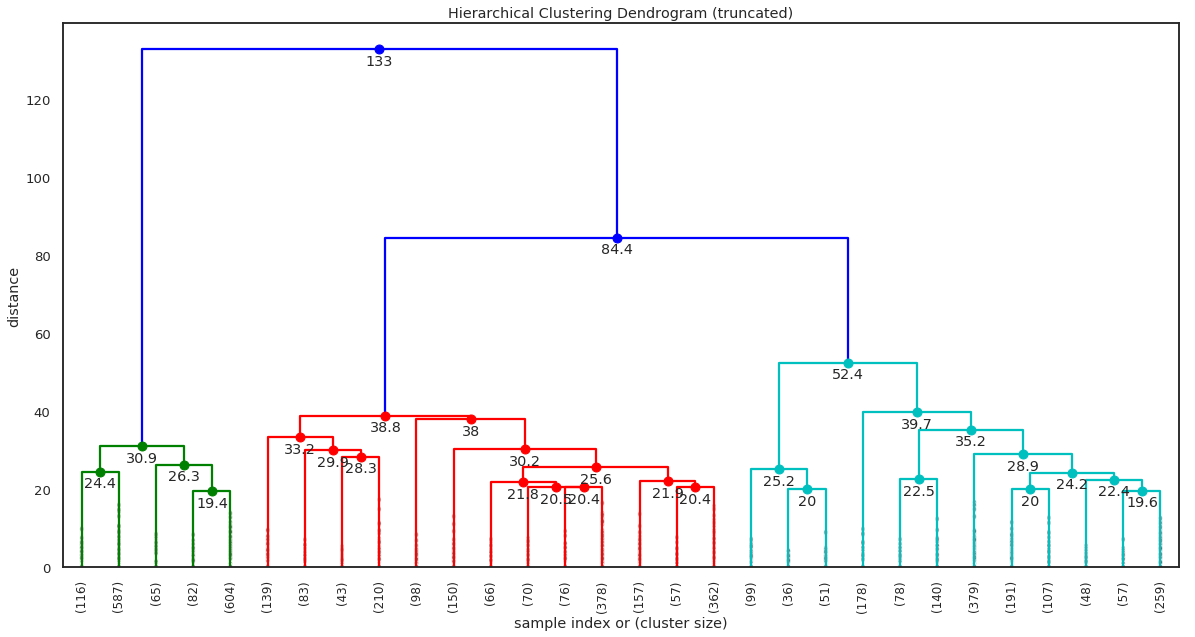

In [36]:
fig, ax = plt.subplots(figsize=(20,10))

ax = fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    color_threshold=color_threshold,
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [37]:
labels = df.medical_specialty
p = len(labels)

R = dendrogram(Z,
               truncate_mode='lastp',  # show only the last p merged clusters
               p=p,  # show only the last p merged clusters
               no_plot=True)

labels = pd.DataFrame(labels)
labels.medical_specialty.value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [38]:
from scipy.cluster.hierarchy import fcluster
max_dist = 30

cluster_labels = fcluster(Z, max_dist, criterion='distance')

cluster_df = df.copy()
cluster_df['f_cluster'] = cluster_labels
cluster_df.head()

,description,medical_specialty,sample_name,transcription,keywords,transcriptions_normal,lemma_transcription,alpha_only,alpha_tokens,f_cluster
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",subjective this 23-year-old white female prese...,subjective this 23-year - old white female pre...,subjective old white female present complaint ...,"[subjective, old, white, female, present, comp...",2
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...",past medical history he has difficulty climbi...,past medical history he have difficulty clim...,past medical history difficulty climb stair di...,"[past, medical, history, difficulty, climb, st...",1
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",history of present illness i have seen abc tod...,history of present illness i have see abc toda...,history present illness see today pleasant gen...,"[history, present, illness, see, today, pleasa...",1
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",2-d m-mode 1 left atrial enlargement with left...,2-d m - mode 1 leave atrial enlargement with l...,mode leave atrial enlargement left atrial diam...,"[mode, leave, atrial, enlargement, left, atria...",8
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",1 the left ventricular cavity size and wall th...,1 the left ventricular cavity size and wall th...,left ventricular cavity size wall thickness ap...,"[left, ventricular, cavity, size, wall, thickn...",8


In [39]:
cluster_df.f_cluster.value_counts()

7     1166
11    1041
2      751
1      703
4      336
10     218
8      186
9      178
6      150
3      139
5       98
Name: f_cluster, dtype: int64

In [40]:
# reduce dimensions to 2 for plotting
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
lsa = svd.fit_transform(similarity_matrix)

xs, ys = lsa[:, 0], lsa[:, 1]

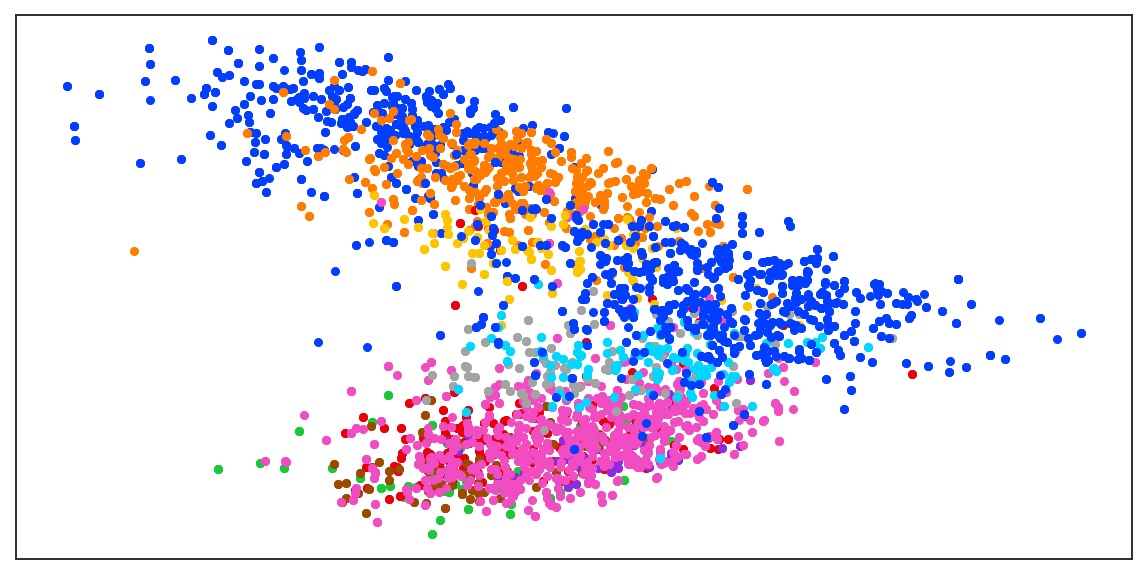

In [41]:
#create data frame that has the result of the SVD plus the cluster numbers and titles
plot = pd.DataFrame(dict(x=xs, y=ys, label=cluster_df.f_cluster, specialty=cluster_df.medical_specialty)) 

#group by cluster
groups = plot.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(20,10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8)
    

    
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
  
    
plt.show();

#### K-Means Clustering

In [42]:
from sklearn.cluster import KMeans

num_clusters = 9

km = KMeans(n_clusters=num_clusters)

%time km.fit_predict(similarity_matrix)

clusters = km.labels_.tolist()

CPU times: user 28.9 s, sys: 1.71 s, total: 30.6 s
Wall time: 22.1 s


In [43]:
cluster_df['kmeans'] = clusters

print(cluster_df.kmeans.value_counts())

cluster_df.sample(5)

8    1104
7     993
6     986
3     766
5     412
4     283
0     188
2     134
1     100
Name: kmeans, dtype: int64


,description,medical_specialty,sample_name,transcription,keywords,transcriptions_normal,lemma_transcription,alpha_only,alpha_tokens,f_cluster,kmeans
3078,Chiropractic IME with answers to questions fr...,Letters,Chiropractic IME - 1,"P.O. Box 12345,City, State ,RE: EXAMINEE : Abc...",NaN,p o box 12345city state re examinee abcclaim...,p o box 12345city state re examinee abccla...,box state examinee abcclaim number injury apri...,"[box, state, examinee, abcclaim, number, injur...",1,6
1119,"Bunionectomy, SCARF type, with metatarsal ost...",Surgery,Bunionectomy & Metatarsal Osteotomy,"PREOPERATIVE DIAGNOSES:,1. Bunion left foot.,...","surgery, hammertoe, osteotomy, internal screw ...",preoperative diagnoses 1 bunion left foot 2 ha...,preoperative diagnosis 1 bunion leave foot 2 h...,preoperative diagnosis bunion leave foot hamme...,"[preoperative, diagnosis, bunion, leave, foot,...",4,5
4313,"Intractable epilepsy, here for video EEG.",Consult - History and Phy.,Intractable Epilepsy,"CHIEF COMPLAINT:, Intractable epilepsy, here ...","consult - history and phy., brain malformation...",chief complaint intractable epilepsy here for ...,chief complaint intractable epilepsy here for ...,chief complaint intractable epilepsy video eeg...,"[chief, complaint, intractable, epilepsy, vide...",1,6
17,Patient status post lap band placement.,Bariatrics,Lap Band Adjustment,"REASON FOR VISIT:, Lap band adjustment.,HISTO...","bariatrics, lap band adjustment, lap band plac...",reason for visit lap band adjustment history o...,reason for visit lap band adjustment history o...,reason visit lap band adjustment history prese...,"[reason, visit, lap, band, adjustment, history...",11,3
1155,Surgical removal of completely bony impacted...,Surgery,Bony Impacted Teeth Removal,"PREOPERATIVE DIAGNOSIS:, Completely bony impa...","surgery, intraoral, bony impacted teeth, throa...",preoperative diagnosis completely bony impacte...,preoperative diagnosis completely bony impact ...,preoperative diagnosis completely bony impact ...,"[preoperative, diagnosis, completely, bony, im...",7,8


In [44]:
kmeans_df = cluster_df.set_index('kmeans')

In [45]:
print('Top terms per cluster: \n')

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):

    print('Cluster %d words:' % i)
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print('  %s' % total_vocab.loc[vocab[ind].split(' ')].values.tolist()[0][0])
        

Top terms per cluster: 

Cluster 0 words:
  daily
  extremity
  long
  cramping
  cortisone
  glan
Cluster 1 words:
  cc
  daily
  flap
  extremity
  cup
  hysterectomy
Cluster 2 words:
  cc
  daily
  flap
  extremity
  cup
  degenerative
Cluster 3 words:
  extremity
  daily
  long
  glan
  betadine
  larynx
Cluster 4 words:
  extremity
  flap
  cc
  daily
  degenerative
  discuss
Cluster 5 words:
  daily
  flap
  extremity
  cc
  deformity
  knife
Cluster 6 words:
  daily
  extremity
  long
  cramping
  cortisone
  glan
Cluster 7 words:
  extremity
  daily
  long
  cortisone
  cramping
  flap
Cluster 8 words:
  daily
  extremity
  flap
  cc
  hysterectomy
  discuss


In [46]:
# reduce dimensions to 2 for plotting
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
lsa = svd.fit_transform(similarity_matrix)

xs, ys = lsa[:, 0], lsa[:, 1]

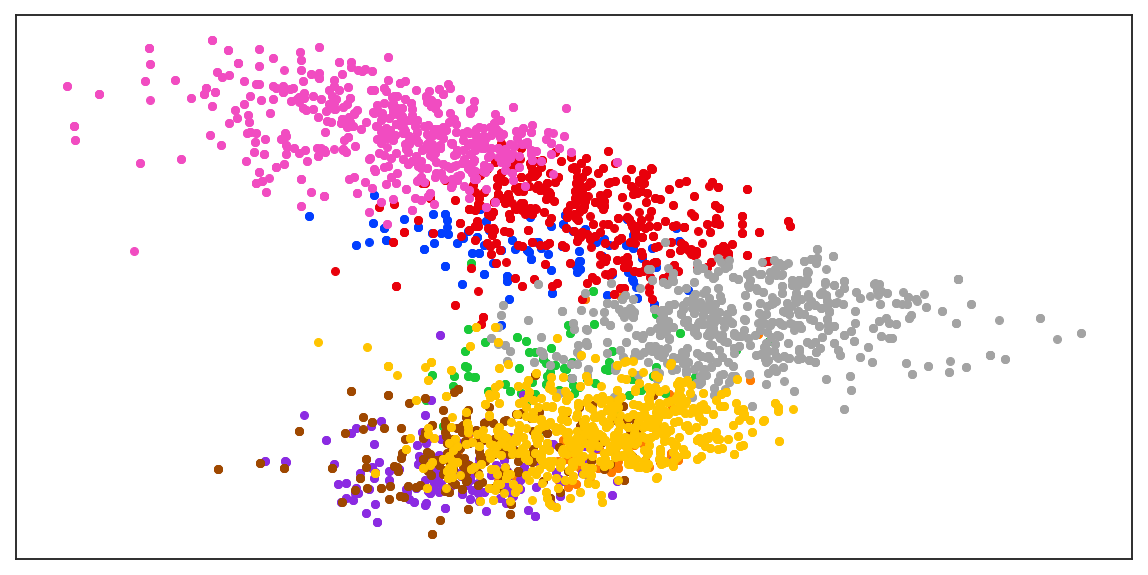

In [47]:
#create data frame that has the result of the SVD plus the cluster numbers and titles
plot = pd.DataFrame(dict(x=xs, y=ys, label=clusters, specialty=cluster_df.medical_specialty)) 

#group by cluster
groups = plot.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(20,10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8)
    

    
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
  
    
plt.show();

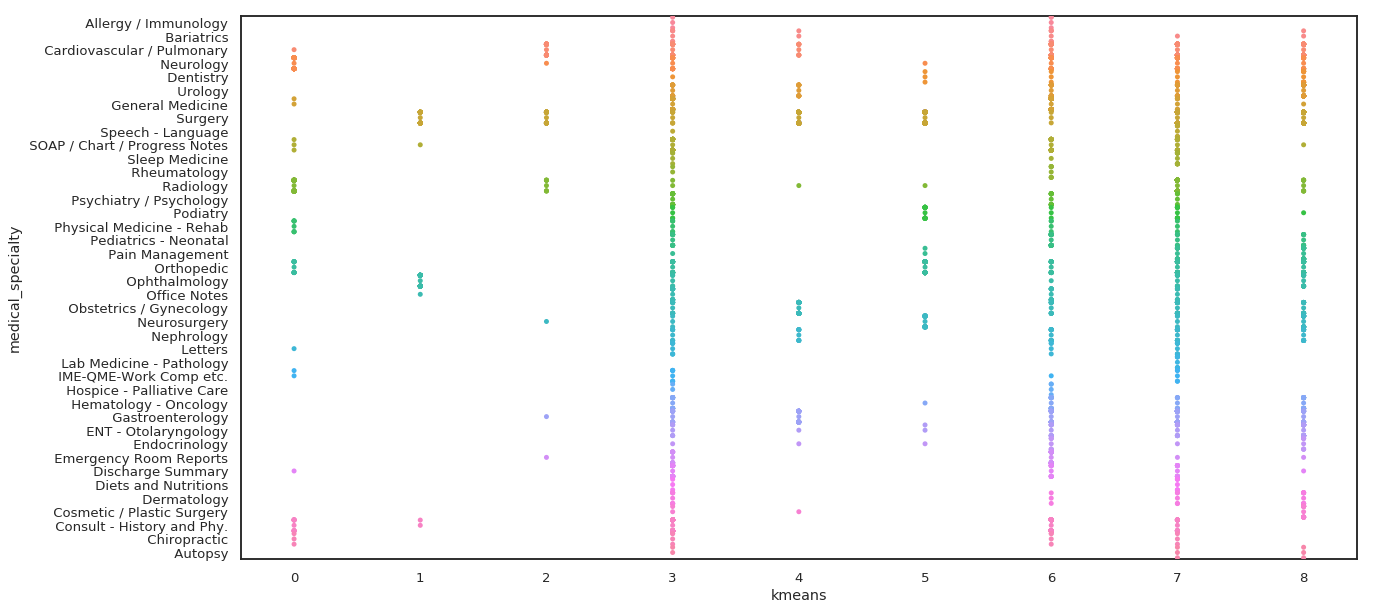

In [60]:
fig, ax = plt.subplots(figsize=(20,10))
sns.swarmplot(y=cluster_df.medical_specialty, x=cluster_df.kmeans);

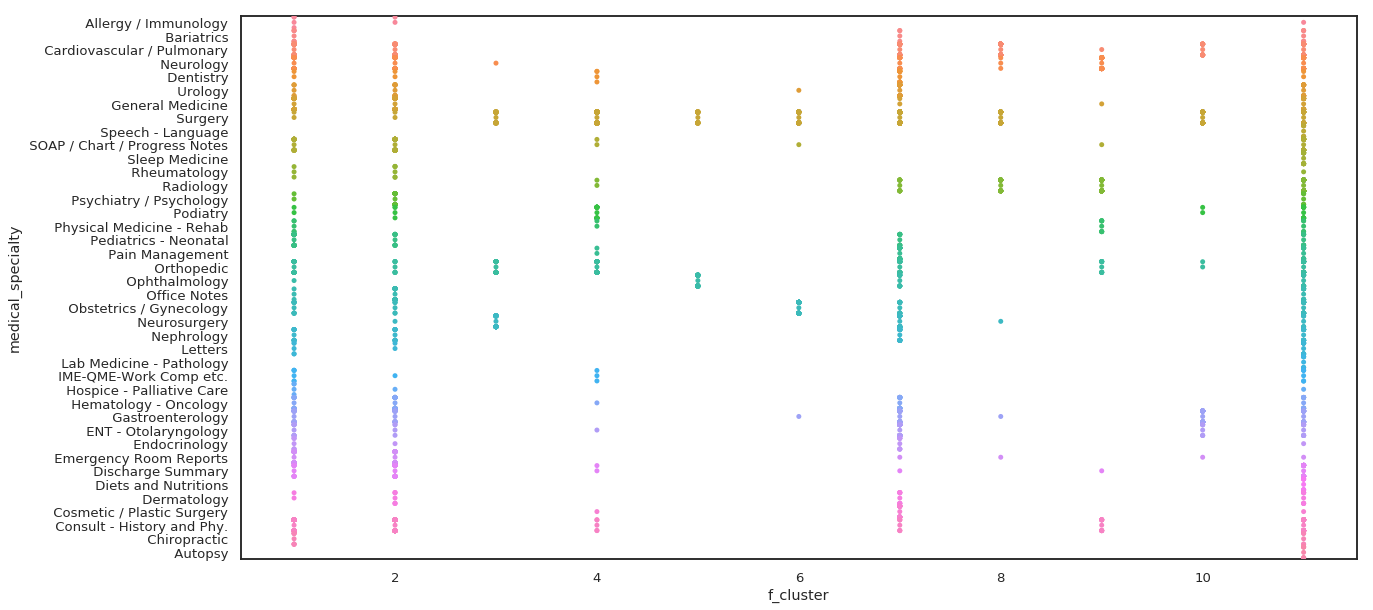

In [61]:
fig, ax = plt.subplots(figsize=(20,10))
sns.swarmplot(y=cluster_df.medical_specialty, x=cluster_df.f_cluster);

It looks like neither clustering strategy was very effective in clustering based on our medical specialties.  Some areas for future exploration would include topic modeling and including named entity recognition to see if we can improve our clusters further.